# Decoding and displaying mystery files

In [1]:
from pathlib import Path

marley  = Path("MARLEY.CHT").read_bytes()
beatles = Path("BEATLES.CHT").read_bytes()
linen   = Path("LINEN.IMG").read_bytes()
kaseta  = Path("KASETA.IMG").read_bytes()

## Decode the files

The decoding divides into three tasks:

1. Figuring out the overall file structure
2. Figuring out what control codes mean
3. Figuring out what the original code pages / fonts looked like

I use the term code pages a lot in here because at least one of the fonts used has graphical characters that remind me of [code page 437](https://en.wikipedia.org/wiki/Code_page_437). The main `decode` function only addresses the first two of these, although thinking about 3 helped solve 1 and 2. In particular, MARLEY has a border around the track listing which makes it much easier to see this file describes a grid of characters. I already suspected the first two words (four bytes) were probably a (width, height) header, though it didn't work out straight away. The missing piece was figuring out that the `0x80` control code jumps forward a variable number of bytes (a kind of run-length encoding): that was possible because it was obvious tha the A and B side track listings should be aligned in columns.

There are still some unresolved parts of this format:

* The other `0x8?` control codes. I've made some guesses what they do, but because they only appear a few times in total at the start of MARLEY and BEATLES, they really only affect the over alignment on the page and headers, so it's hard to know for sure. Obvious possibilities like skip forward 1,2,3,4,5 or 1,2,4,8,16 don't produce sensible layouts.
* The final word of the file. At first I thought this might fill in the rest of the page or something, but that would be unnecessary. My best guess is they're some kind of checksum over the whole file, either a XOR or two's complement or CRC-16 or something like that. I didn't try too hard to figure this out as if my guess is right, it doesn't affect display.

The fonts themselves I discuss below. There's even more uncertainty there, but I made some plausible guesses.

In [2]:
def wrap(s, n):
    return([s[i:i+n] for i in range(0, len(s), n)])

In [3]:
def decode(b, width=None, height=None, skip1=10, skip2=50, fillchar=None):
    """
    Decode bytes b into a list of lines, which are themselves lists of (character, code page) pairs.
    By default the width and height stored in the first two 16-bit words will be used, but these can
    be specified as arguments (mostly a debugging feature).
    """
    
    # First 4 bytes seem to be 16-bit width and 16-bit height, stored little endian
    width = width or int.from_bytes(b[0:2], 'little')
    height = height or int.from_bytes(b[2:4], 'little')
    
    # Initialize an output buffer with spaces in the default font, and an index into it
    outbuffer = [(None, None)] * (width * height)
    o = 0
    
    for i in range(4, len(b), 2):
        data, ctrl = b[i:i+2]
        
        # High bit seems to indicate a pure control / nondisplay character
        if ctrl & 0x80:       
            # Skip [data] places rightwards
            if   ctrl == 0x80:
                o = o + data
                
            # These occur near the start of the CHT but not the IMG files
            # By analog with 0x80, they probably skip in some direction, but which?
            elif ctrl == 0x81:
                o = o - data
                pass
            elif ctrl == 0x83: # Must be forwards
                o = o + data * skip1
                pass
            elif ctrl == 0x84: # Must be forwards
                o = o + data * skip2
                pass

            # We see 0x99 and 0xC4 at the end of MARLEY and BEATLES respectively
            # I suspect these are actually checksum bytes, XOR or sum or CRC-16 or something
            # so for now I ignore them at the end.
            else:
                if i + 2 == len(b):
                    pass # checksum bytes
                else:
                    raise ValueError(f"Unknown control sequence {data:02x} {ctrl:02x} at position {i}")
        else:                             # Display character with code page
            outbuffer[o] = (data, ctrl)
            o = o + 1
        
    # For debugging, fill up the rest of the buffer
    if fillchar:
        fillcount = 0
        while o < len(outbuffer):
            outbuffer[o] = (int.from_bytes(fillchar.encode("ascii"), "little"), 0)
            o = o + 1
            fillcount += 1
            
    return (width, height), wrap(outbuffer[:o], width)

## Render the files (approximately) as text

If the second byte in a word is not a control character, it seems to always be constant suggesting a font set / code page. From the files provided we can deduce:
  * `0x00` Bold (or some other heading style)
  * `0x01` Normal
  * `0x02` Symbols/graphics, not unlike those in [code page 437](https://en.wikipedia.org/wiki/Code_page_437#Character_set)
  * `0x06` Subscript / superscript / some other font
      * this is the most puzzling one
      * use for track listing, but only lower case, in BEATLES suggests some sort of text variant
      * but use in the linear algebra context in LINEN means it must contain both subscript and superscript
      * only conclusion is a mixed ASCII-like code page laid out for keyboard entry, with
          * Lower case letters: I chose italics, which matches the casual-ness of the lower-case track listing, but small caps would also explain the lack of upper case.
          * Numbers as subscript
          * "Upper case" numbers (ie. shift-numbers) as superscript
      
There are also three sets of code pages that work together:
  * A first double-wide font (bold?) with characters split into two halves, where
    * `0x0D` contains the left half
    * `0X0E` contains the right half
  * A second double-wide font (normal?) with characters split into two halves, where
    * `0x0F` contains the left half
    * `0X10` contains the right half
  * A double-wide / double-height font with characters split into four quadrants, where
    * `0x11` contains the top left quadrant
    * `0x12` contains the top right quadrant
    * `0x13` contains the bottom left quadrant
    * `0x14` contains the bottom right quadrant
    
It is easy to see that the non-graphical code pages are ASCII-like, but since we don't have access to the graphical code page `0x02`, we have to figure out what it looked like. Code page 437 itself doesn't work, but it turns out to be mostly easy to deduce the mapping based on context in the provided files, with a few less certain guesses. We capture that as a mapping to unicode characters.

In [4]:
codes_0x02 = {
    # It's either these or the single-line variants, and I favour double here as the ones below
    # are used in LINEN for determinants and that notation is typically a single vertical bar
    0x26: '╦',
    0x27: '╠',
    0x28: '╣',
    0x29: '╩',
    0x30: '║',
    0x31: '═',
    0x32: '╔',
    0x33: '╗',
    0x34: '╚',
    0x35: '╝',

    # These are much less certain guesses from context in LINEN. The context as a determinant
    # in LINEN suggests that 0x40 is a single vertical bar, and because they're consecutive
    # codes we can assume 0x41 is a horizontal single line by analogy with 0x30, 0x31.
    0x40: '│',
    0x41: '─'
}

In [5]:
def render_str(decoded_file, bgchar=" "):
    """
    Render a list of list of (character, code page) pairs into a unicode string approximation
    """
    chargrid = decoded_file[1]
    
    # The only code page decoded is graphics, all else is treated as ASCII
    def render_str_char(c, codepage):
        if c is None:
            return bgchar
        else:
            if codepage == 0x02:
                return codes_0x02[c]
            else:
                return c.to_bytes(1, 'little').decode("ascii")
    
    def render_str_line(l):
        return "".join(render_str_char(c, codepage) for c, codepage in l)
    
    return '\n'.join(render_str_line(l) for l in chargrid)

In [6]:
print(render_str(decode(marley)))

Tada! That's cool, obviously, but it's a bit unsatisfying not to see, especially, the doubled characters as they should be. I couldn't find any unicode code points for split characters like this, and I'm not sure I even know what terms to search for to find existing bitmap fonts like this. But I can probably make some. Also there are a bunch of characters that don't make sense, especially in LINEN: that could be fixed.

This is very clearly the point when I have gone too far with this exercise...

## Make the necessary bitmap fonts

To make this work pixel-perfect—which is necessary for the borders to line up well—we need bitmap fonts. ~~These look perfect, and even include 2x scaled fonts which we can cut up into quadrants:~~

~~https://int10h.org/oldschool-pc-fonts/download/~~

Actually I didn't use those, I used these other ones instead, because they already bold, italic and 2x size, all of which I'll need:

https://github.com/wikkyk/leggie

That also meant the conversion step was not as complex as below, because they're already in BDF format. However, I still had to use FontForge because, a little ironically, Python PIL/pillow ImageFonts can only use the first 256 characters of a font, so I had to remap the Leggie fonts into code page 437 after all, just as if we were still in the early 1990s. But that done, you can skip to the code below...

---

~~To process this, it looks like the PIL/Pillow libraries [support bitmap fonts, but in its own proprietary .pil format](https://github.com/python-pillow/pillow-scripts/blob/main/Scripts/pilfont.py). There is a converter to that format from BDF and PCF fonts. But the oldschool fonts come (as bitmaps) in either FON or OTB. Remember life before TrueType? To review:~~

* ~~[BDF](https://en.wikipedia.org/wiki/Glyph_Bitmap_Distribution_Format), Glyph Bitmap Distribution Format, is an Adobe format from the 1980s.~~
* ~~[PCF](https://en.wikipedia.org/wiki/Portable_Compiled_Format), Portable Compiled Format is an X-Windows standard, which apparently replaced BDF for that purpose. ~~
* ~~[FON](http://fileformats.archiveteam.org/wiki/FON) is the Windows 3.x file format, so also from the 1980s, more or less. But still [in use in embedded things](https://github.com/fontforge/fontforge/issues/3841#issuecomment-747398859)!~~
* ~~[OTB](https://en.wikipedia.org/wiki/OpenType) is Opentype Bitmap~~

~~The last thing I want to do now is write a font file reader, but thankfully I discovered [FontForge](https://fontforge.org/en-US/), an excellent open source font utility.~~

In [7]:
# If necessary:
#!pip install pillow

In [8]:
from PIL import BdfFontFile, Image, ImageFont, ImageDraw
from glob import glob

First convert the basis fonts and load them:

In [9]:
for fn in glob("./fonts/*.bdf"):
    with open(fn, "rb") as f:
        font = BdfFontFile.BdfFontFile(f)
        font.save(f"{fn}.pil")

In [10]:
font        = ImageFont.load("fonts/leggie-12-cp437.bdf.pil")
font_bold   = ImageFont.load("fonts/leggie-12b-cp437.bdf.pil")
font_italic = ImageFont.load("fonts/leggie-12i-cp437.bdf.pil")
font_2x     = ImageFont.load("fonts/leggie-24-cp437.bdf.pil")
font_2xbold = ImageFont.load("fonts/leggie-24b-cp437.bdf.pil")

We have to do a lot of glyph resizing and repositioning so a flexible function helps:

In [11]:
def make_glyph(code, font, size, topleft=(0,0), scale=(1,1), bgcolor="black", fgcolor="white", mode="RGB"):
    """
    Make a PIL image with the glyph at code in font drawn at topleft and scaled to scale,
    where topleft and scale are both specified in a [0,1] x [0,1] coordinate system over
    the output image of dimensions size.
    """
    code = code.to_bytes(1, 'little')
    fontsize = font.getsize(code)
    
    # Initialize the image at the fontsize and draw the text to fill it
    im_char = Image.new(mode, fontsize, color=bgcolor)
    draw = ImageDraw.Draw(im_char)
    draw.text((0,0), code, font=font, fill=fgcolor)
    
    # Resize the image to the dimensions the character should fill
    im_char = im_char.resize((int(size[0] * scale[0]), int(size[1] * scale[1])))
    
    # Make the final output image and paste the character into it
    im_out = Image.new(mode, size, color=bgcolor)
    im_out.paste(im_char, (int(size[0] * topleft[0]), int(size[1] * topleft[1])))
    
    return im_out

This section looks ugly but it's basically just a set of code page / font definitions.

In [12]:
# Normal
def glyphs_normal(bgcolor="black", fgcolor="white"):
    return {
        code: make_glyph(code, font, (12,24), bgcolor=bgcolor, fgcolor=fgcolor) for code in range(256)
    }

# Double wide
def glyphs_doublewide_left(bgcolor="black", fgcolor="white"):
    return {
        code: make_glyph(code, font_2x, (12,24), (0,0), (2,1), bgcolor=bgcolor, fgcolor=fgcolor) for code in range(256)
    }

def glyphs_doublewide_right(bgcolor="black", fgcolor="white"):
    return {
        code: make_glyph(code, font_2x, (12,24), (-1,0), (2,1), bgcolor=bgcolor, fgcolor=fgcolor) for code in range(256)
    }

# Double wide, double high
def glyphs_doubledouble_topleft(bgcolor="black", fgcolor="white"):
    return {
        code: make_glyph(code, font_2x, (12,24), (0,0), (2,2), bgcolor=bgcolor, fgcolor=fgcolor) for code in range(256)
    }
    
def glyphs_doubledouble_topright(bgcolor="black", fgcolor="white"):
    return {
        code: make_glyph(code, font_2x, (12,24), (-1,0), (2,2), bgcolor=bgcolor, fgcolor=fgcolor) for code in range(256)
    }

def glyphs_doubledouble_bottomleft(bgcolor="black", fgcolor="white"):
    return {
        code: make_glyph(code, font_2x, (12,24), (0,-1), (2,2), bgcolor=bgcolor, fgcolor=fgcolor) for code in range(256)
    }

def glyphs_doubledouble_bottomright(bgcolor="black", fgcolor="white"):
    return {
        code: make_glyph(code, font_2x, (12,24), (-1,-1), (2,2), bgcolor=bgcolor, fgcolor=fgcolor) for code in range(256)
    }

# Bold
def glyphs_bold(bgcolor="black", fgcolor="white"):
    return {
        code: make_glyph(code, font_bold, (12,24), bgcolor=bgcolor, fgcolor=fgcolor) for code in range(256)
    }

# Italic
def glyphs_italic(bgcolor="black", fgcolor="white"):
    return {
        code: make_glyph(code, font_italic, (12,24), bgcolor=bgcolor, fgcolor=fgcolor) for code in range(256)
    }

# Double wide bold
def glyphs_doublewidebold_left(bgcolor="black", fgcolor="white"):
    return {
        code: make_glyph(code, font_2xbold, (12,24), (0,0), (2,1), bgcolor=bgcolor, fgcolor=fgcolor) for code in range(256)
    }

def glyphs_doublewidebold_right(bgcolor="black", fgcolor="white"):
    return {
        code: make_glyph(code, font_2xbold, (12,24), (-1,0), (2,1), bgcolor=bgcolor, fgcolor=fgcolor) for code in range(256)
    }

# Subscript
def glyphs_subscript(bgcolor="black", fgcolor="white"):
    return {
        code: make_glyph(code, font, (12,24), (0, 0.25), (0.75, 0.75), bgcolor=bgcolor, fgcolor=fgcolor) for code in range(256)
    }

# Superscript
def glyphs_superscript(bgcolor="black", fgcolor="white"):
    return {
        code: make_glyph(code, font, (12,24), (0, 0), (0.75, 0.75), bgcolor=bgcolor, fgcolor=fgcolor) for code in range(256)
    }

# Special: combines italic, subscript and subscript in one code page
def glyphs_special(bgcolor="black", fgcolor="white"):
    shift_numbers = "!@#$%^&*()".encode("ascii")
    ita = glyphs_italic(bgcolor, fgcolor)
    sup = glyphs_superscript(bgcolor, fgcolor)
    sub = glyphs_subscript(bgcolor, fgcolor)
    g = ita.copy()
    g.update(dict(
        [(c, g) for c, g in sup.items() if 0x30 <= c <= 0x39] +
        [(shift_numbers[offset], sub[0x30 + offset]) for offset in range(10)] +
        [(int.from_bytes("<".encode("ascii"), "little"), ita[int.from_bytes("'".encode("ascii"), "little")])]
    ))
    return g

# Graphic
def glyphs_graphic(bgcolor="black", fgcolor="white"):
    return {
        code: make_glyph(int.from_bytes(char.encode("cp437"), "little"), font, (12, 24), bgcolor=bgcolor, fgcolor=fgcolor) for code, char in codes_0x02.items()
    }

## Render the files as images

In [13]:
def render_img(decoded_file, default_glyphs, codepage_glyphs={}, bgcolor="black"):
    pagesize, chargrid = decoded_file

    # Infer the character size from default glyphs
    charsize = next(iter(default_glyphs.values())).size
    
    page = Image.new("RGB", (pagesize[0]*charsize[0], pagesize[1]*charsize[1]), color=bgcolor)
    
    x = 0
    y = 0
    for row in chargrid:
        for c, codepage in row:
            if c is not None:
                glyphs = codepage_glyphs.get(codepage, default_glyphs)
                g = glyphs[c]
                page.paste(g, (x,y))
            x += charsize[0]
        y += charsize[1]
        x = 0
    
    return page

In [14]:
glyph_map = {
    0x00: glyphs_bold(),
    0x02: glyphs_graphic(),
    0x06: glyphs_special(),
    0x0D: glyphs_doublewidebold_left(),
    0x0E: glyphs_doublewidebold_right(),
    0x0F: glyphs_doublewide_left(),
    0x10: glyphs_doublewide_right(),
    0x11: glyphs_doubledouble_topleft(),
    0x12: glyphs_doubledouble_topright(),
    0x13: glyphs_doubledouble_bottomleft(),
    0x14: glyphs_doubledouble_bottomright()
}

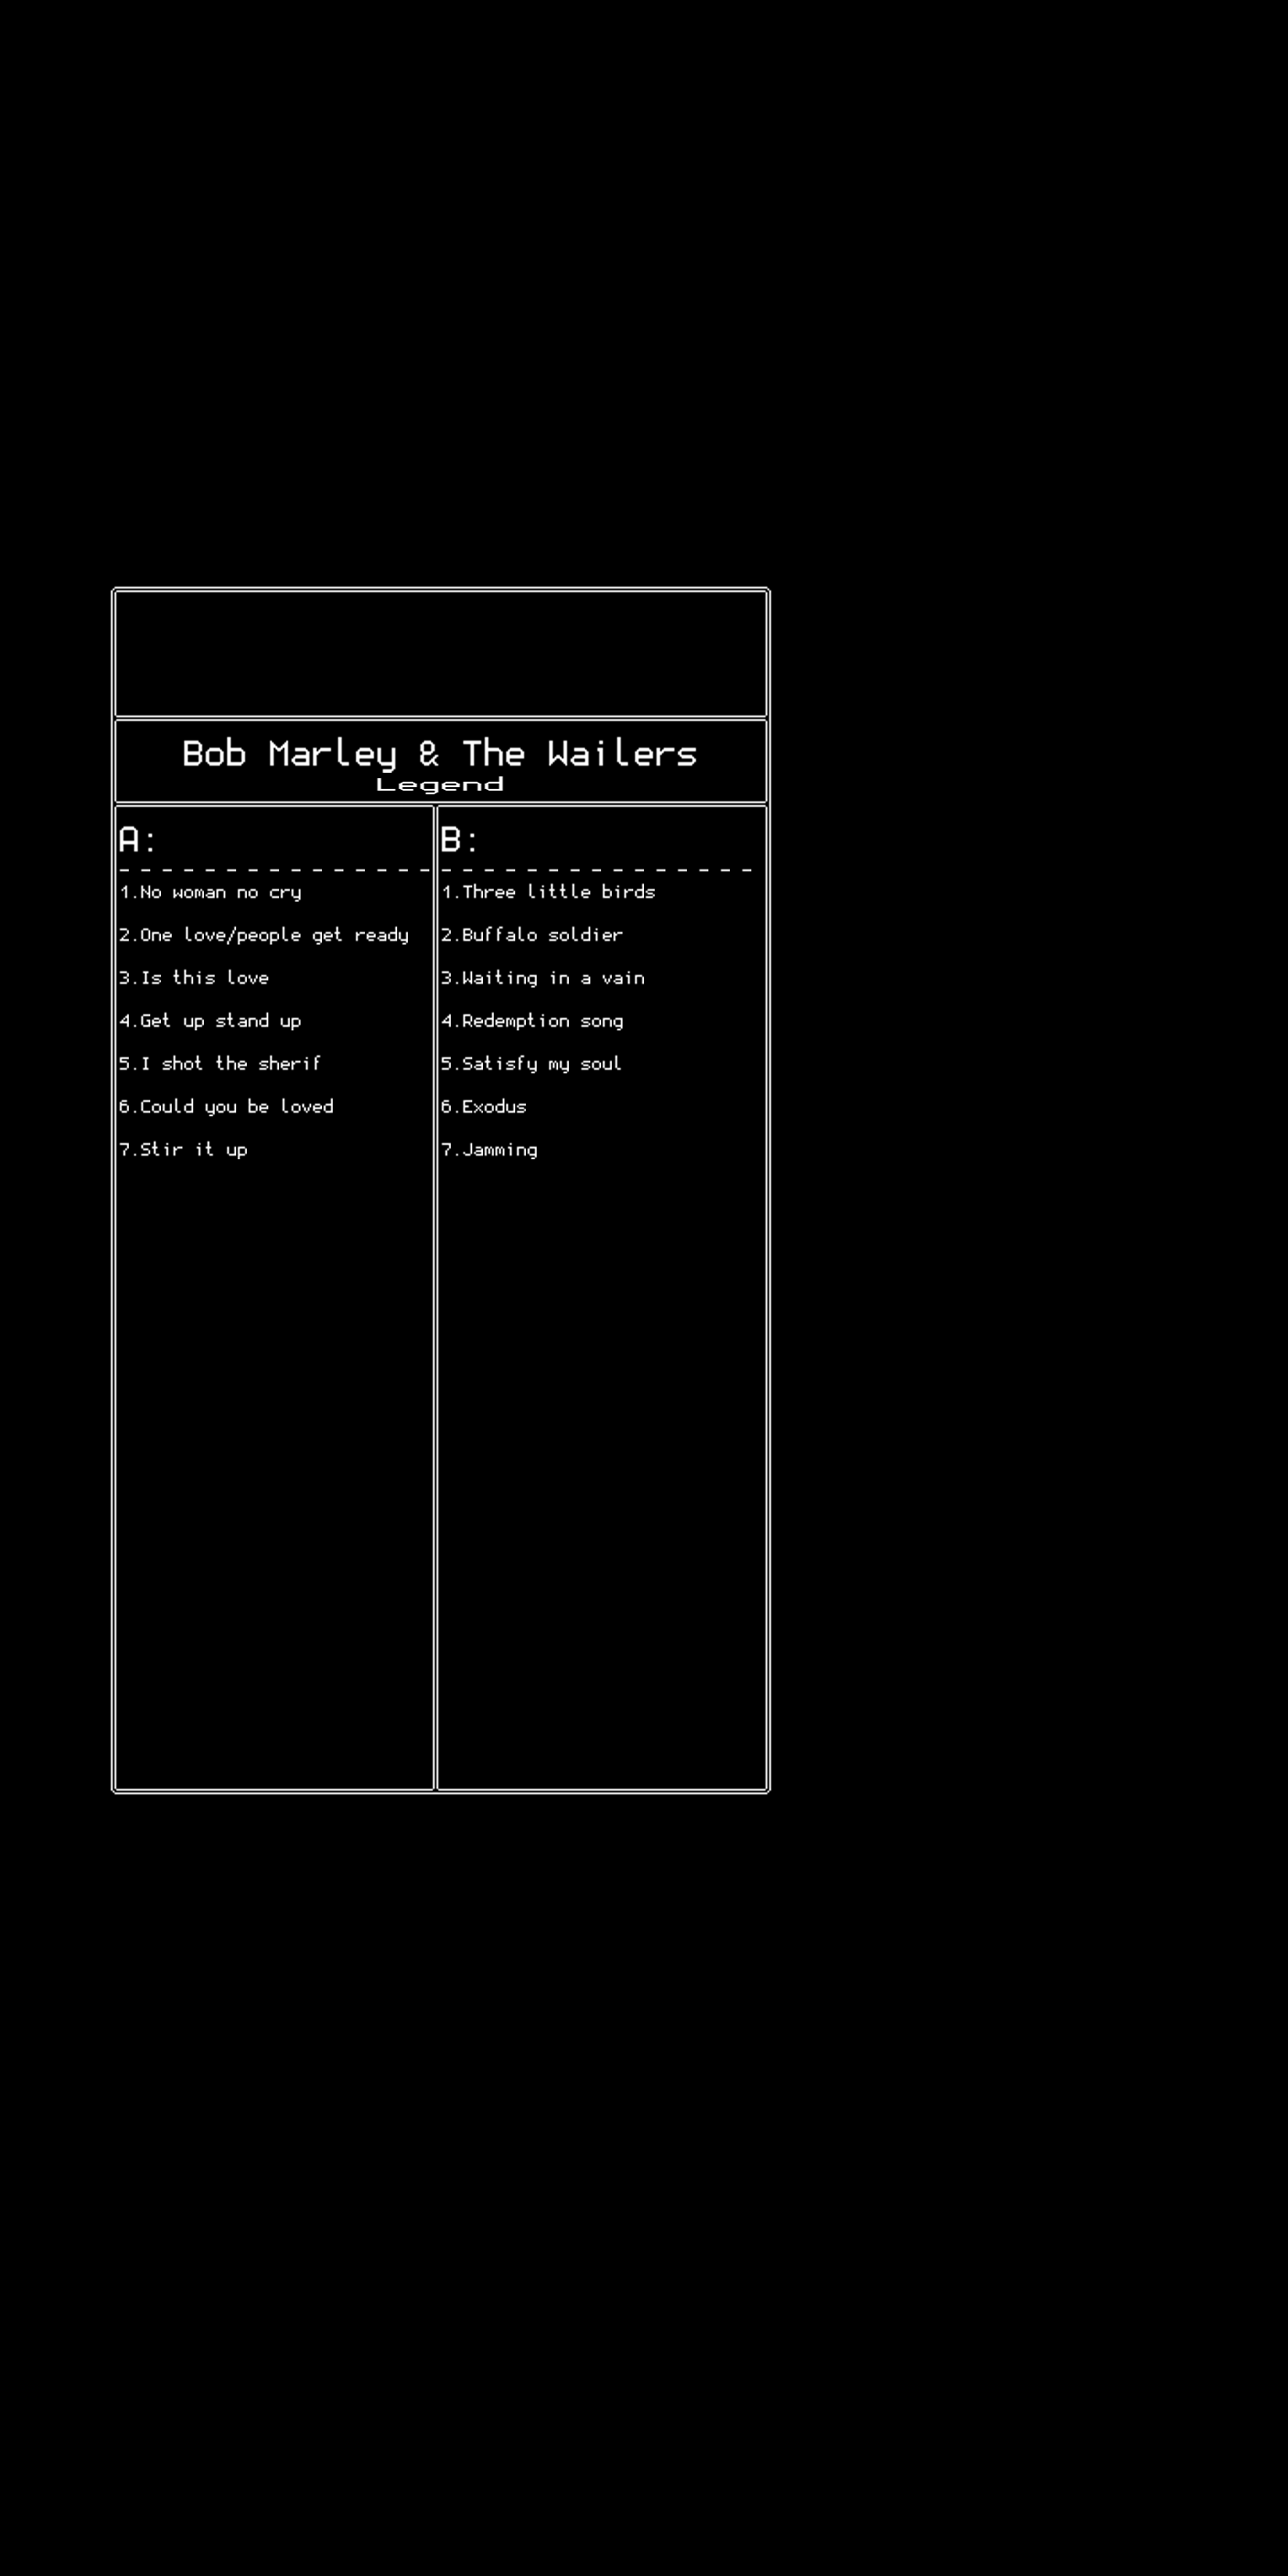

In [15]:
render_img(decode(marley), glyphs_normal(), glyph_map)

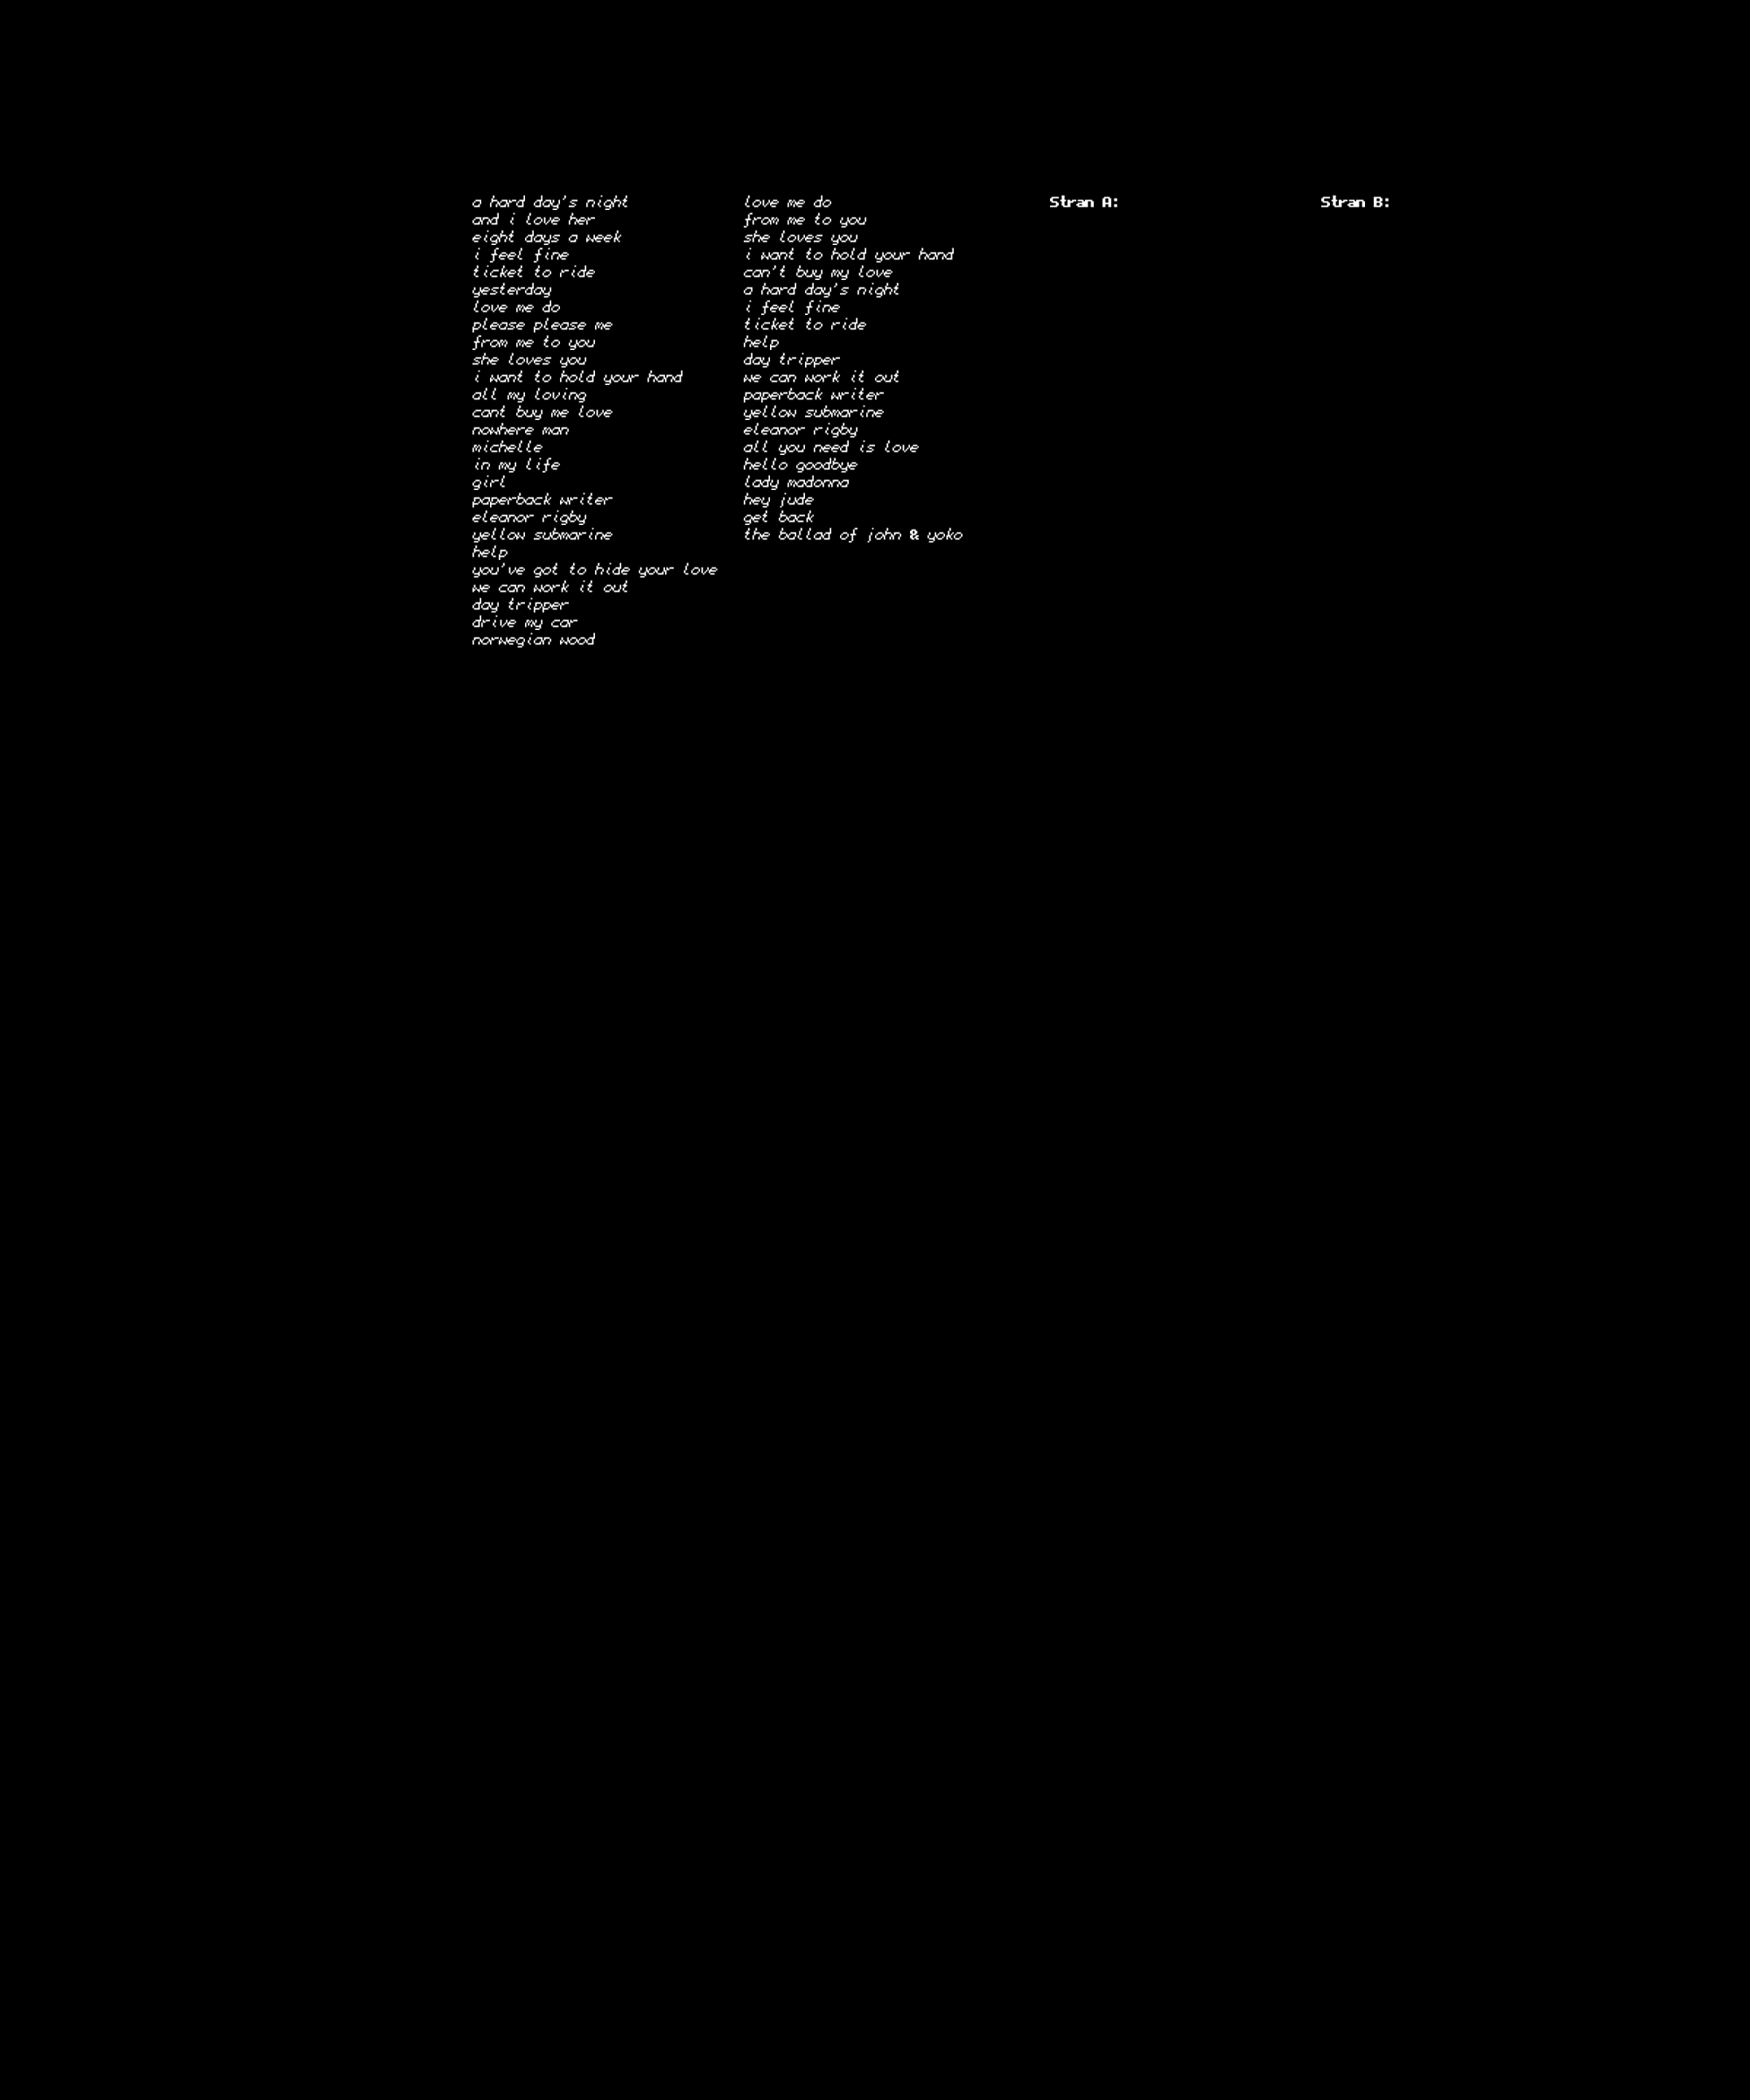

In [16]:
render_img(decode(beatles), glyphs_normal(), glyph_map)

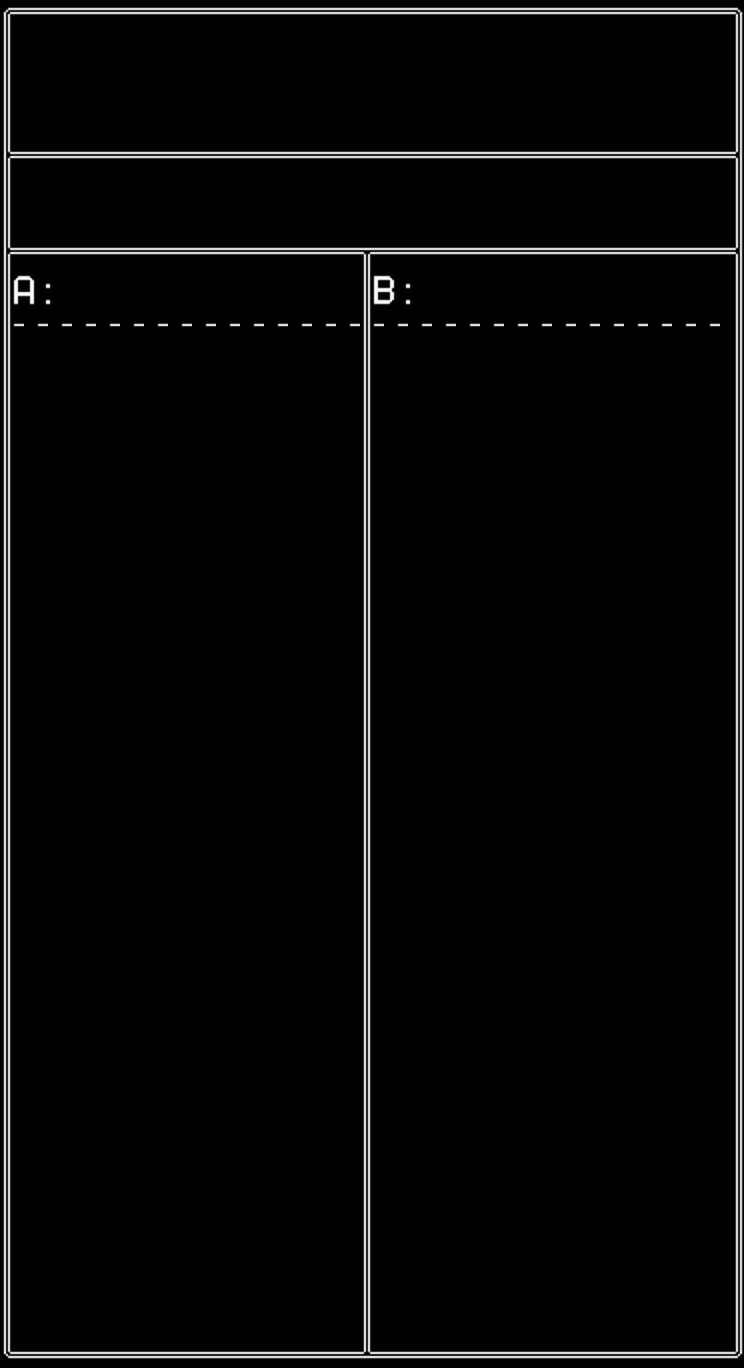

In [17]:
render_img(decode(kaseta), glyphs_normal(), glyph_map)

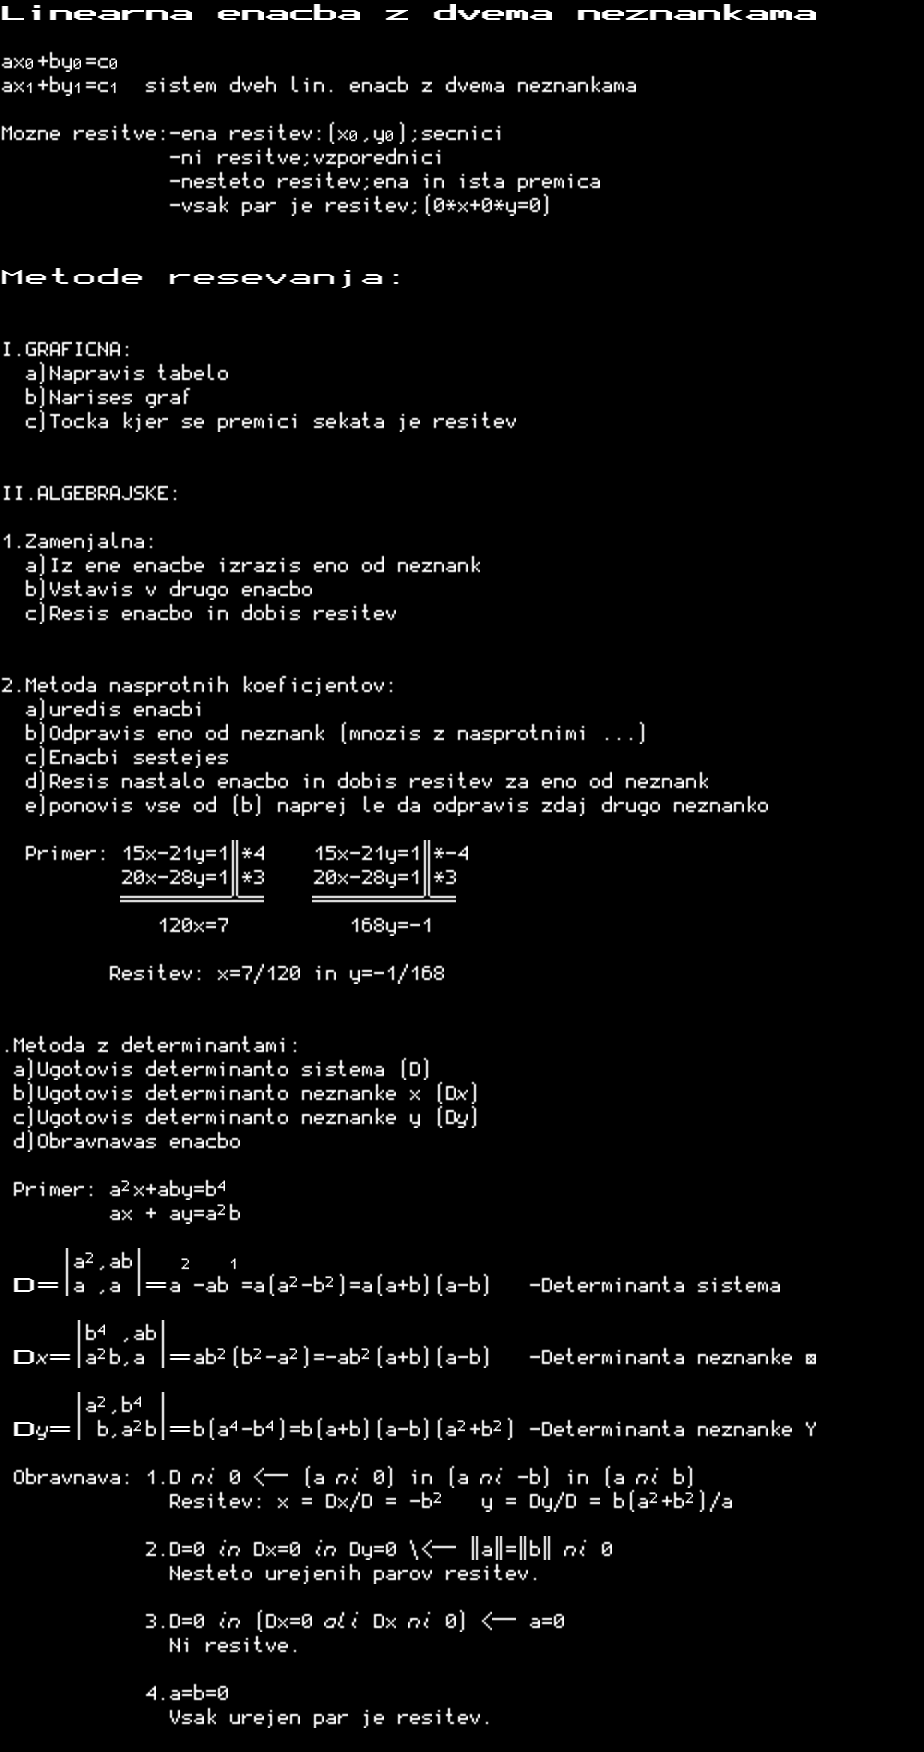

In [18]:
render_img(decode(linen), glyphs_normal(), glyph_map)

## Extra: show the different fonts used

We can show how complicated the font use is by coloring them differently.

In [19]:
glyph_map_rainbow = {
    0x00: glyphs_bold("red"),
    0x02: glyphs_graphic("gold"),
    0x06: glyphs_special("pink"),
    0x0D: glyphs_doublewidebold_left("green"),
    0x0E: glyphs_doublewidebold_right("purple"),
    0x0F: glyphs_doublewide_left("orange"),
    0x10: glyphs_doublewide_right("blue"),
    0x11: glyphs_doubledouble_topleft("cyan"),
    0x12: glyphs_doubledouble_topright("grey"),
    0x13: glyphs_doubledouble_bottomleft("brown"),
    0x14: glyphs_doubledouble_bottomright("darkblue")
}

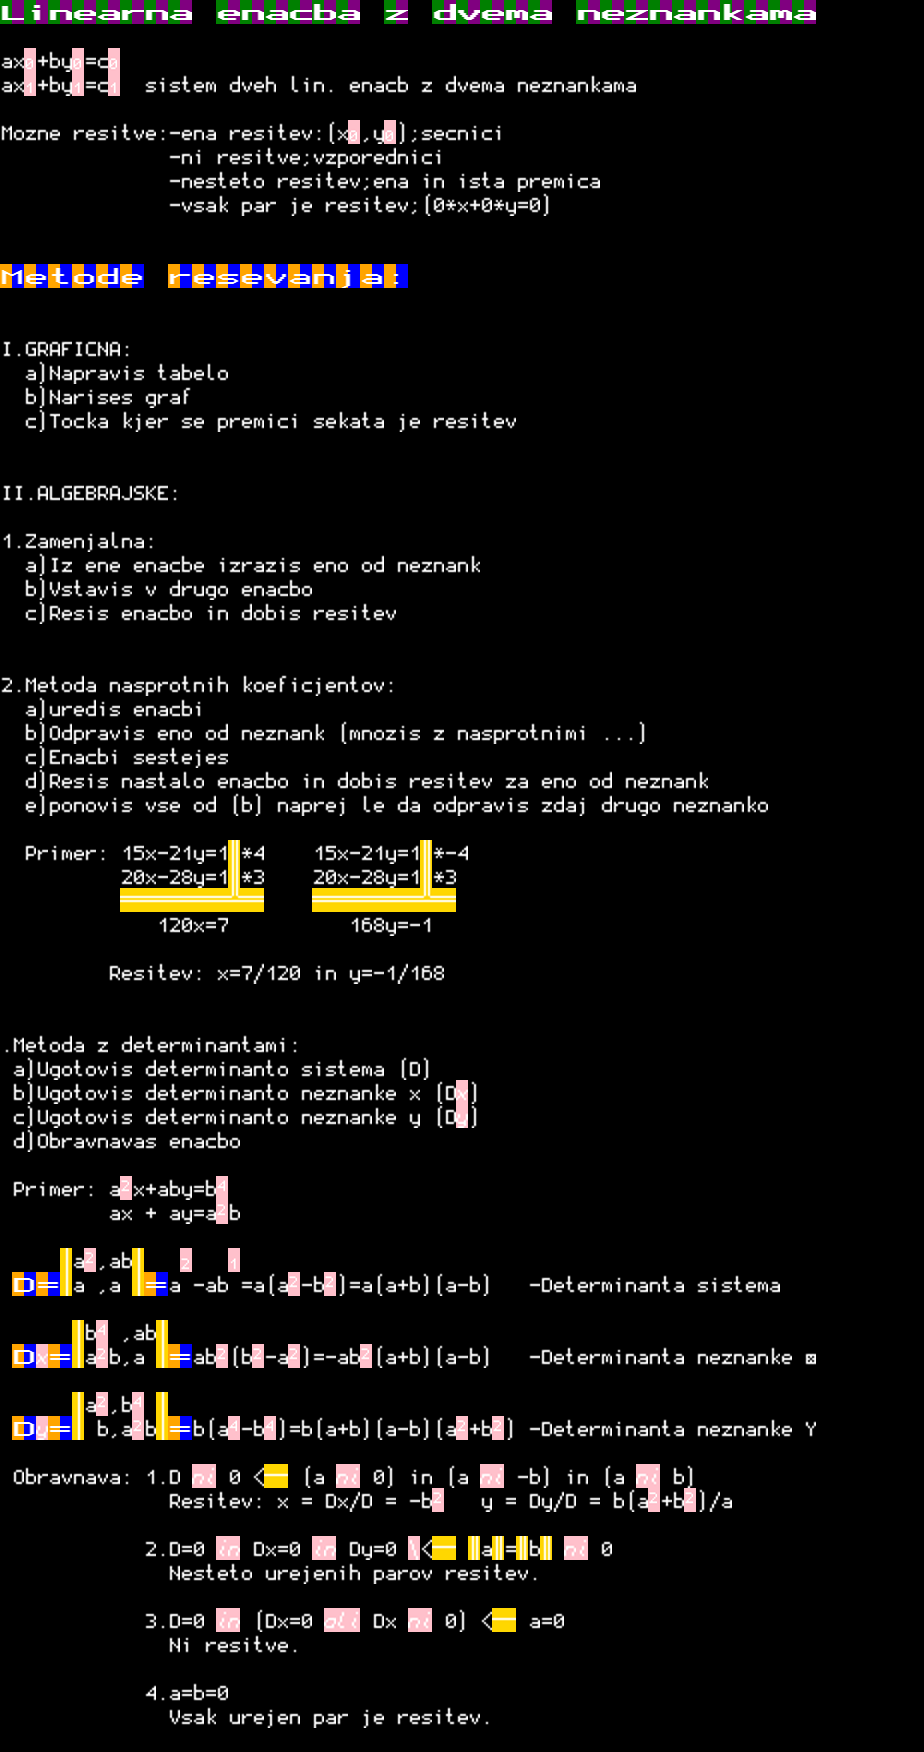

In [20]:
render_img(decode(linen), glyphs_normal(), glyph_map_rainbow)

## Extra: show the different code pages

In [21]:
demo = (
    (32, 8),
    [[(thirtytwos * 32 + ones, 0) for ones in range(0, 32)] for thirtytwos in range(0, 8)]
)

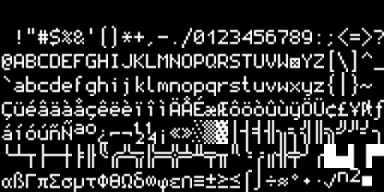

In [22]:
render_img(demo, glyphs_normal())

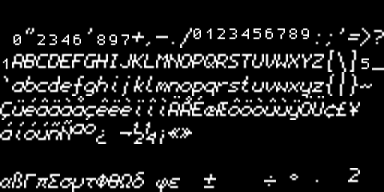

In [23]:
render_img(demo, glyphs_special())

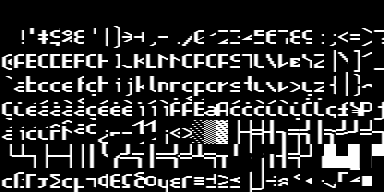

In [24]:
render_img(demo, glyphs_doublewide_left())